In [2]:
from gcm import GCM
import numpy as np
import pandas as pd
from IPython.display import display

# Step 1: Load Data

In [66]:
df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv", nrows = 5000)
numeric_df = df.select_dtypes(include="number")
numeric_df = numeric_df.dropna(axis=1).iloc[:,2:]  # Drop columns with NaNs

columns_to_drop = ['policy_code', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths','delinq_amnt', 'tax_liens','pub_rec_bankruptcies']
numeric_df = numeric_df.drop(columns=columns_to_drop)


/tmp/ipykernel_12845/3315786745.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv", nrows = 5000)


# Step 2: Check Multivariate Correlation

In [77]:
def compute_multipole(df: pd.DataFrame, columns: list, method="pearson"):
    corr_matrix = df[columns].corr(method=method)
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    multipole = 1 - min(eigenvalues)
    return multipole

# Higher utility, higher balance, lower credit score
s1 = ['all_util','tot_cur_bal','last_fico_range_high']

# mortgage accounts, total balances, credit limits
s2 = ['mort_acc','tot_hi_cred_lim','total_bal_ex_mort']

# Number of revolving accounts (num_rev_accts) interacts with utilization and delinquency.
s3 = ['num_rev_accts','all_util','num_accts_ever_120_pd']

# Delinquencies for 2 years, public records, and collection recovery fee:
s4 = ['delinq_2yrs', 'pub_rec', 'collection_recovery_fee']

scenarios = [s1, s2, s3,s4]

# Initialize a dictionary to store results
scenarios_dict = {i: {'columns': s, 'Original Multipole': None, 'Synthetic Multipole': None} for i, s in enumerate(scenarios)}

# Compute multipole for each scenario
for i, s in enumerate(scenarios):
    multipole_val = compute_multipole(numeric_df, s, method="pearson")
    scenarios_dict[i]['Original Multipole'] = multipole_val
    print(f"Columns: {s}, Multipole: {multipole_val:.4f}")


Columns: ['all_util', 'tot_cur_bal', 'last_fico_range_high'], Multipole: 0.2612
Columns: ['mort_acc', 'tot_hi_cred_lim', 'total_bal_ex_mort'], Multipole: 0.6759
Columns: ['num_rev_accts', 'all_util', 'num_accts_ever_120_pd'], Multipole: 0.2448
Columns: ['delinq_2yrs', 'pub_rec', 'collection_recovery_fee'], Multipole: 0.0029


# Step 3: Fit GCM and Generate Synthetic Data

In [78]:
# 1. Initialize the GCM model and fit it to your source data
gcm = GCM()
gcm.fit(numeric_df)

# # 2. Generate synthetic samples
synthetic_data = gcm.sample(num_samples=50000)

# 3. Verify that the correlation structure is preserved
corr_real = np.corrcoef(numeric_df, rowvar=False)
corr_synth = np.corrcoef(synthetic_data, rowvar=False)

Correlation matrix:
 [[ 1.          0.99999839  0.17199788 ...  0.24614827  0.36294979
   0.17224599]
 [ 0.99999839  1.          0.17192969 ...  0.24615392  0.36295865
   0.17225362]
 [ 0.17199788  0.17192969  1.         ...  0.03338966 -0.23984241
   0.03159894]
 ...
 [ 0.24614827  0.24615392  0.03338966 ...  1.          0.22321925
   0.90923064]
 [ 0.36294979  0.36295865 -0.23984241 ...  0.22321925  1.
   0.06549202]
 [ 0.17224599  0.17225362  0.03159894 ...  0.90923064  0.06549202
   1.        ]]


# Step 4: Validate Results

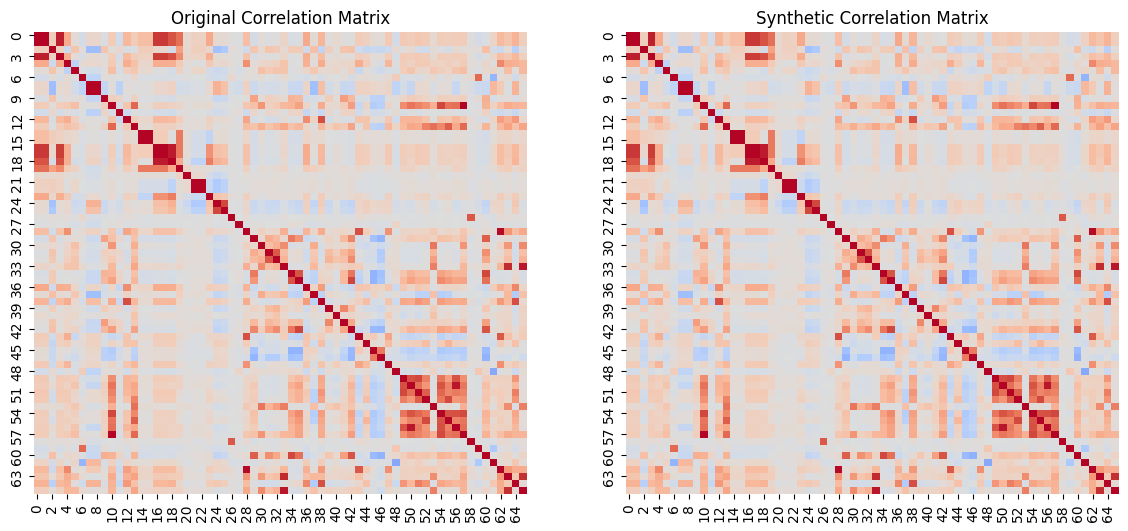

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(corr_real, ax=axes[0], cmap="coolwarm", center=0, cbar=False)
axes[0].set_title("Original Correlation Matrix")

sns.heatmap(corr_synth, ax=axes[1], cmap="coolwarm", center=0, cbar=False)
axes[1].set_title("Synthetic Correlation Matrix")

plt.show()


In [82]:
# Are the multipoles preserved?
for i, s in enumerate(scenarios):
    scenarios_dict[i]['Synthetic Multipole'] = compute_multipole(pd.DataFrame(synthetic_data, columns=numeric_df.columns), s, method="pearson")
    
# Convert to DataFrame
df = pd.DataFrame.from_dict(scenarios_dict, orient='index')

# Format numeric columns nicely
numeric_cols = ['Original Multipole', 'Synthetic Multipole']
df[numeric_cols] = df[numeric_cols].applymap(lambda x: f"{x:.4f}" if x is not None else "-")
display(df)


,columns,Original Multipole,Synthetic Multipole
0,"[all_util, tot_cur_bal, last_fico_range_high]",0.2612,0.2731
1,"[mort_acc, tot_hi_cred_lim, total_bal_ex_mort]",0.6759,0.6737
2,"[num_rev_accts, all_util, num_accts_ever_120_pd]",0.2448,0.2414
3,"[delinq_2yrs, pub_rec, collection_recovery_fee]",0.0029,0.0069
